In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ase import Atoms

from y2ace_funcs import *


# Dataset characteristics

## Pair distance distribution

In [7]:
os.chdir("/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace/")
# es01_dataset = load_gzip('datasets/es01.pckl.gzip')
tr1k_dataset = load_gzip('datasets/Carbon_full/Tr1k_n.pckl.gzip')
dia1k_dataset = load_gzip('datasets/Tr1k_dia.pckl.gzip')

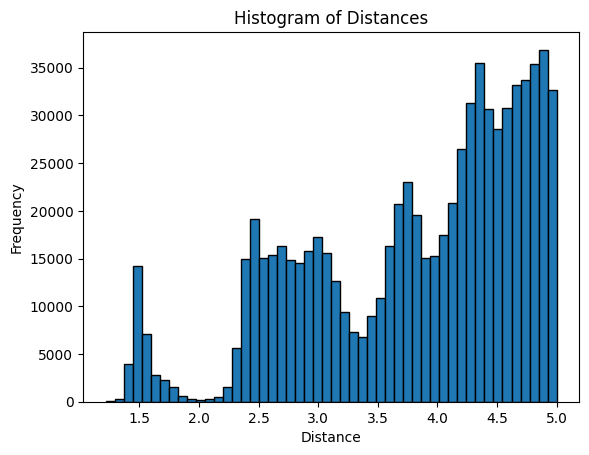

In [8]:
dists = np.array([])
for atoms in dia1k_dataset['ase_atoms']:
    dists = np.append(dists, strucs2dists(atoms,rcut=5,warn=False))

distcount, edges = np.histogram(dists, bins=50)
plt.bar(edges[:-1], distcount / 2, width=np.diff(edges), align='edge', edgecolor='black')
# plt.bar(edges[:-1], distcount, width=np.diff(edges), align='edge', edgecolor='black', alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.show()

## Histogram from reference diamond structure

# Loss and dimer curves

## Dimers 

In [2]:
pwd()

'/leonardo_work/Sis25_degironc_0/apol/aceconverge2025'

In [ ]:
# acepotentials.jl files
os.chdir('acejulia/')
en_acejl_pot_1 = np.loadtxt('acejulia/Tr124_dim/border3/dimercurve.dat').T
en_acejl_pot_2 = np.loadtxt('acejulia/Tr124_dim/border4/dimercurve.dat').T

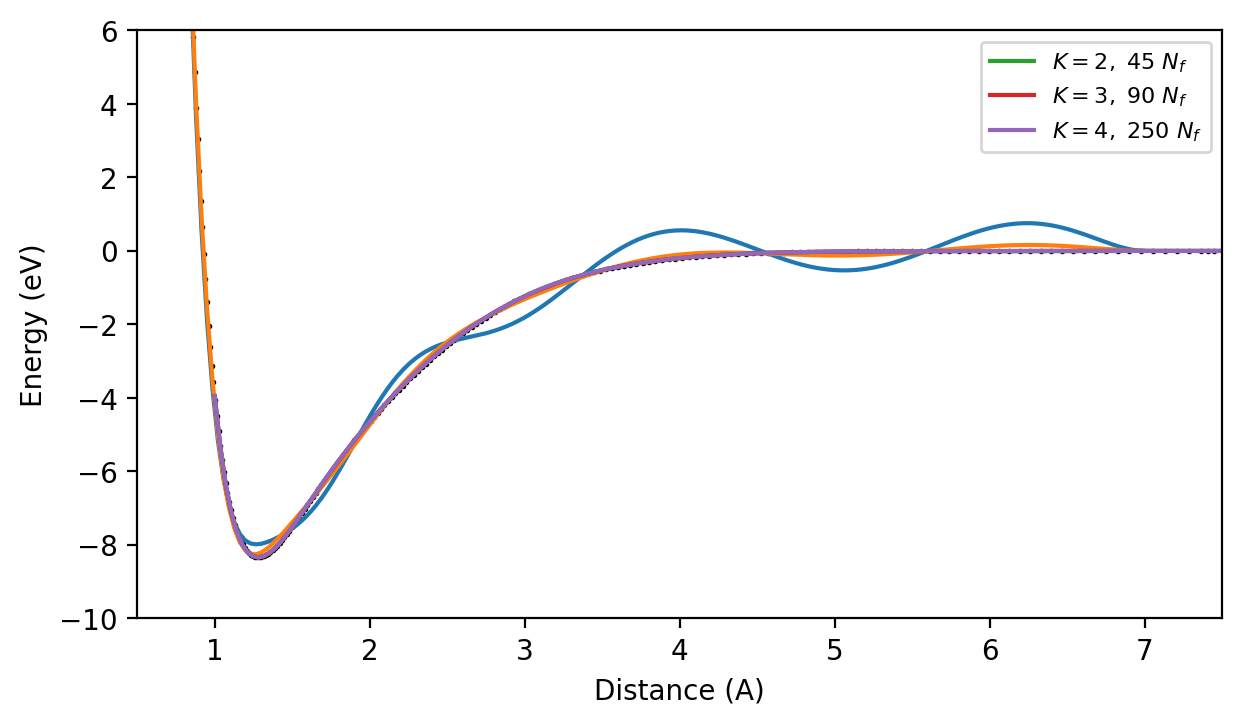

In [12]:
# pacemaker-related files
os.chdir('/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace')
r = np.linspace(1,8,200)
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV

potdirs = ['datafiles/Tr124_dim/border/b_order'+str(i)+'/' for i in range(2,5)]
datasets = [r'$K=2,$ $45$ $N_f$', r'$K=3,$ $90$ $N_f$', r'$K=4,$ $250$ $N_f$']

g,gax = plt.subplots(1,1,figsize=(7,3.5),dpi=200)
# g.suptitle(plot_title)
g.subplots_adjust(top=0.95)
# gax.scatter(*en_qe,s=1,color='k',label='DFT')

# DFT data
gax.scatter(*en_qe,s=1,color='k')

# ACE-JL
for acejl in [en_acejl_pot_1, en_acejl_pot_2]:
    gax.plot(*acejl)

# pacemaker
for i,dir in enumerate(potdirs):
    gax.plot(r, en_ase(r, dir, 'output_potential.yaml'), label=datasets[i])
gax.set_xlabel('Distance (A)')
gax.set_ylabel('Energy (eV)')
# gax.set_xlim(1.1391207805825228,7.5)
gax.set_xlim(0.5,7.5)
gax.set_ylim(-10,6)
gax.legend(fontsize=8)
# g.savefig('figures/curvestab_dim124_abstract.png',bbox_inches='tight')

## Diamonds

## Diverse

In [2]:
## Data loading
kappa_list = ['kappa30times', 'kappa50times', 'kappa100times', 'kappa500times']
kappa_trainerr = np.array([np.loadtxt('datafiles/Tr1k_n/'+kappa+'/b_order4/train_rmse.dat').T for kappa in kappa_list])
kappa_testerr = np.array([np.loadtxt('datafiles/Tr1k_n/'+kappa+'/b_order4/train_rmse.dat').T for kappa in kappa_list])

# Others

## Loss balancing 

### Original loss balancing

(350.0, 600.0)

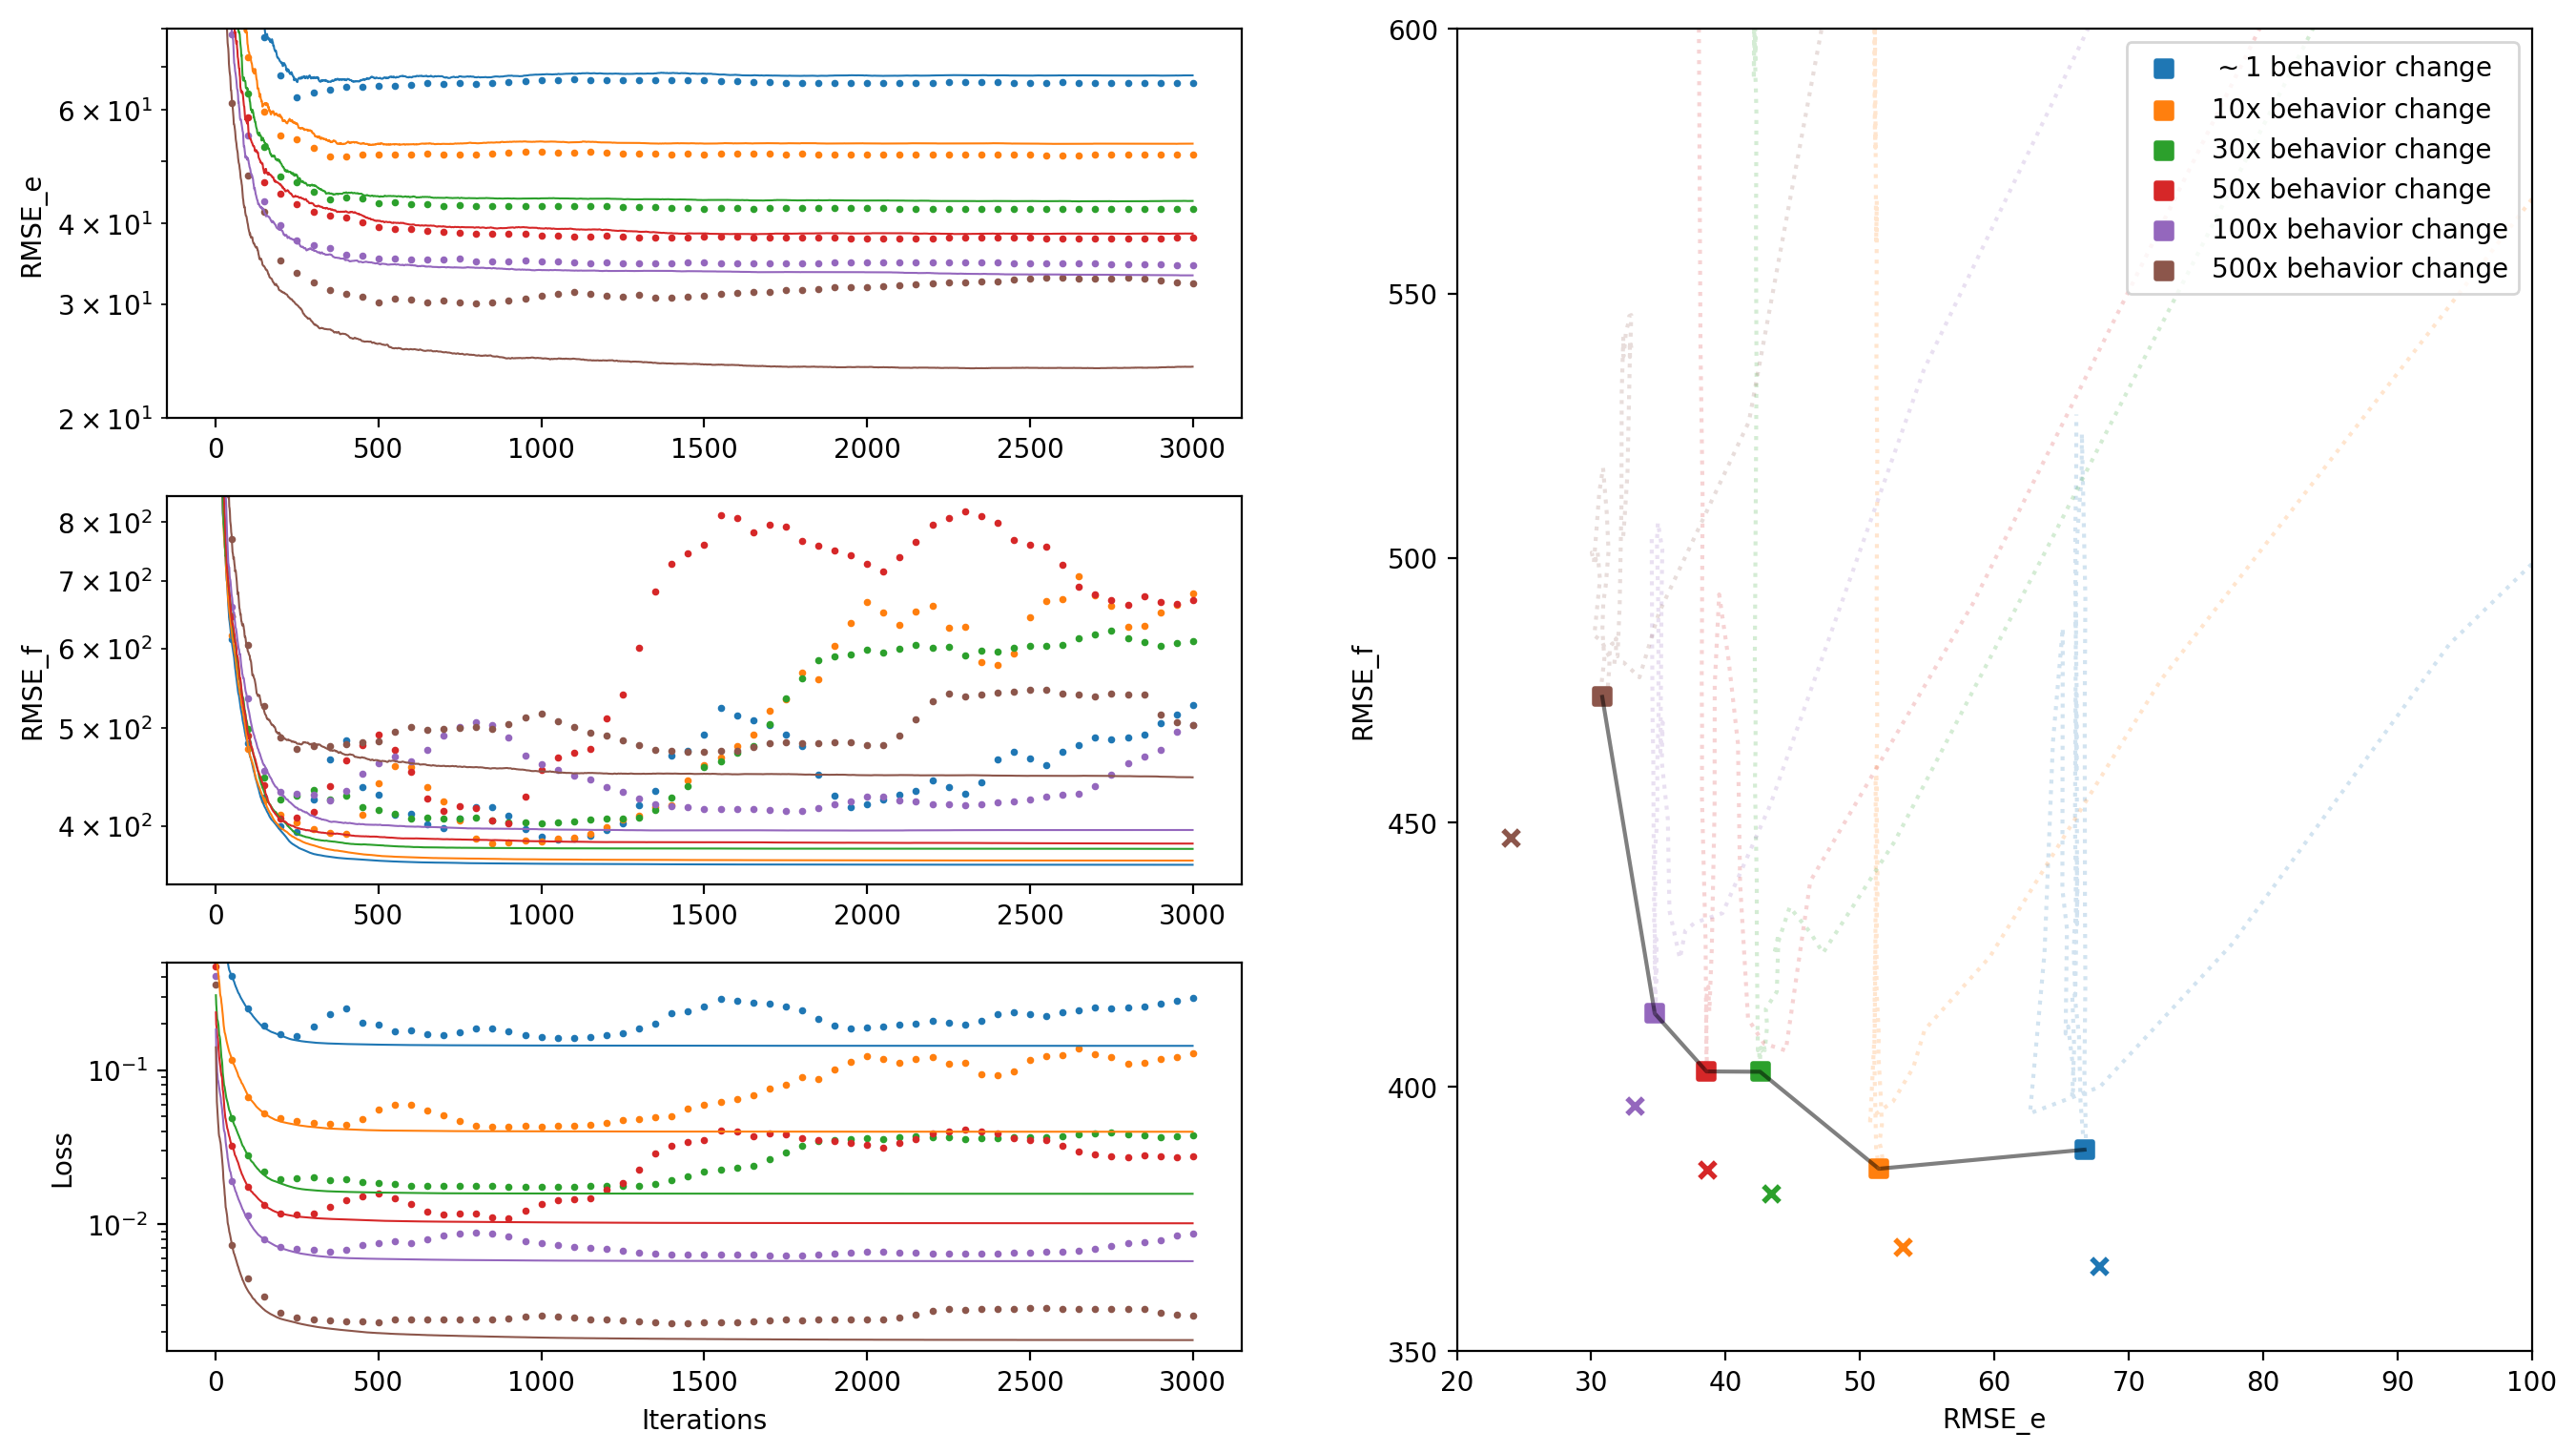

In [95]:
# Data loading
datadir = 'datafiles/Tr1k_n/'
kappa_list = ['1shot_1kval','kappa10times','kappa30times', 'kappa50times', 'kappa100times', 'kappa500times']
kappa_labels = [f'$\sim 1$', '10x', '30x', '50x', '100x', '500x']

kappa_itertrain = np.array([np.loadtxt(datadir+kappa+'/b_order4/lrnrate.dat').T for kappa in kappa_list]) # original is (entry, (iter,loss,rmse_e,rmse_f),iter)
kappa_iterval = np.array([np.loadtxt(datadir+kappa+'/b_order4/vallrn_l.dat').T for kappa in kappa_list]) # iter, loss
iterval_ef = np.array([np.loadtxt(datadir+kappa+'/b_order4/vallrn_ef.dat').T for kappa in kappa_list]) # rmse_e, rmse_f

# original is (Nf, loss, rmse_e, rmse_f)
kappa_trainerr = np.array([np.loadtxt(datadir+kappa+'/b_order4/train_rmse.dat').T for kappa in kappa_list]) 
kappa_testerr = np.array([np.loadtxt(datadir+kappa+'/b_order4/test_rmse.dat').T for kappa in kappa_list])

# identical for all runs 
iters = kappa_itertrain[0,0,:] # training iterations
iters_val = kappa_iterval[0][0] # validation iterations
iterval_ef_norm = np.linalg.norm(iterval_ef, axis=1) # norms of validation errors for Le, Lf

# Index and "coordinates" of minimal validation error 
overfit_ind = np.argmin(iterval_ef_norm, axis=1)

iterval_ef_of = np.array([iterval_ef[i,:,overfit_ind[i]] for i in range(len(overfit_ind))])


f = plt.figure(figsize=(16,9),dpi=200)

axle = f.add_subplot(321); axlf = f.add_subplot(323); axl = f.add_subplot(325)
lax = [axle,axlf,axl]
axlelf = f.add_subplot(122)
for ax in lax:
    ax.set_yscale('log')

for i,loss in enumerate(kappa_itertrain[:,2,:]):
    axle.plot(iters,loss,lw=0.75)
    axle.scatter(iters_val,iterval_ef[i,0],s=3)
axle.set_ylim(20,80)
axle.set_ylabel('RMSE_e')

for i,loss in enumerate(kappa_itertrain[:,3,:]):
    axlf.plot(iters,loss,lw=0.75)
    axlf.scatter(iters_val,iterval_ef[i,1],s=3)
axlf.set_ylim(350,850)
axlf.set_ylabel('RMSE_f')

for i,loss in enumerate(kappa_itertrain[:,1,:]):
    axl.plot(iters,loss,lw=0.75)
    axl.scatter(iters_val,kappa_iterval[i,1],s=3)
axl.set_ylim(1.5e-3,5e-1)
axl.set_ylabel('Loss')
axl.set_xlabel('Iterations')

for i,trainerr in enumerate(kappa_trainerr):
    # axlelf.scatter(*trainerr[1:3]*1e3, label=kappa_labels[i], color='C'+str(i), marker='x', linewidth=2)
    axlelf.scatter(*trainerr[1:3]*1e3, label='_', color='C'+str(i), marker='x', linewidth=2)

axlelf.plot(*iterval_ef_of.T,'k-',alpha=0.5)
for i,testerr in enumerate(iterval_ef_of):
    axlelf.scatter(*testerr, label=kappa_labels[i]+' behavior change', color='C'+str(i), marker='s',linewidth=2)
for k,errtraj in enumerate(iterval_ef):
    axlelf.plot(*errtraj,':',color='C'+str(k),alpha=0.2)


# for i,testerr in enumerate(kappa_testerr):
#     axlelf.scatter(*testerr[1:3], label=kappa_labels[i]+' test', color='C'+str(i), linewidth=2)
axlelf.legend(loc='upper right')
axlelf.set_ylabel('RMSE_f')
axlelf.set_xlabel('RMSE_e')
axlelf.set_xlim(20,100); axlelf.set_ylim(350,600)
# axlelf.set_yscale('log')
# axlelf.set_xscale('log')

### Early cut loss balancing

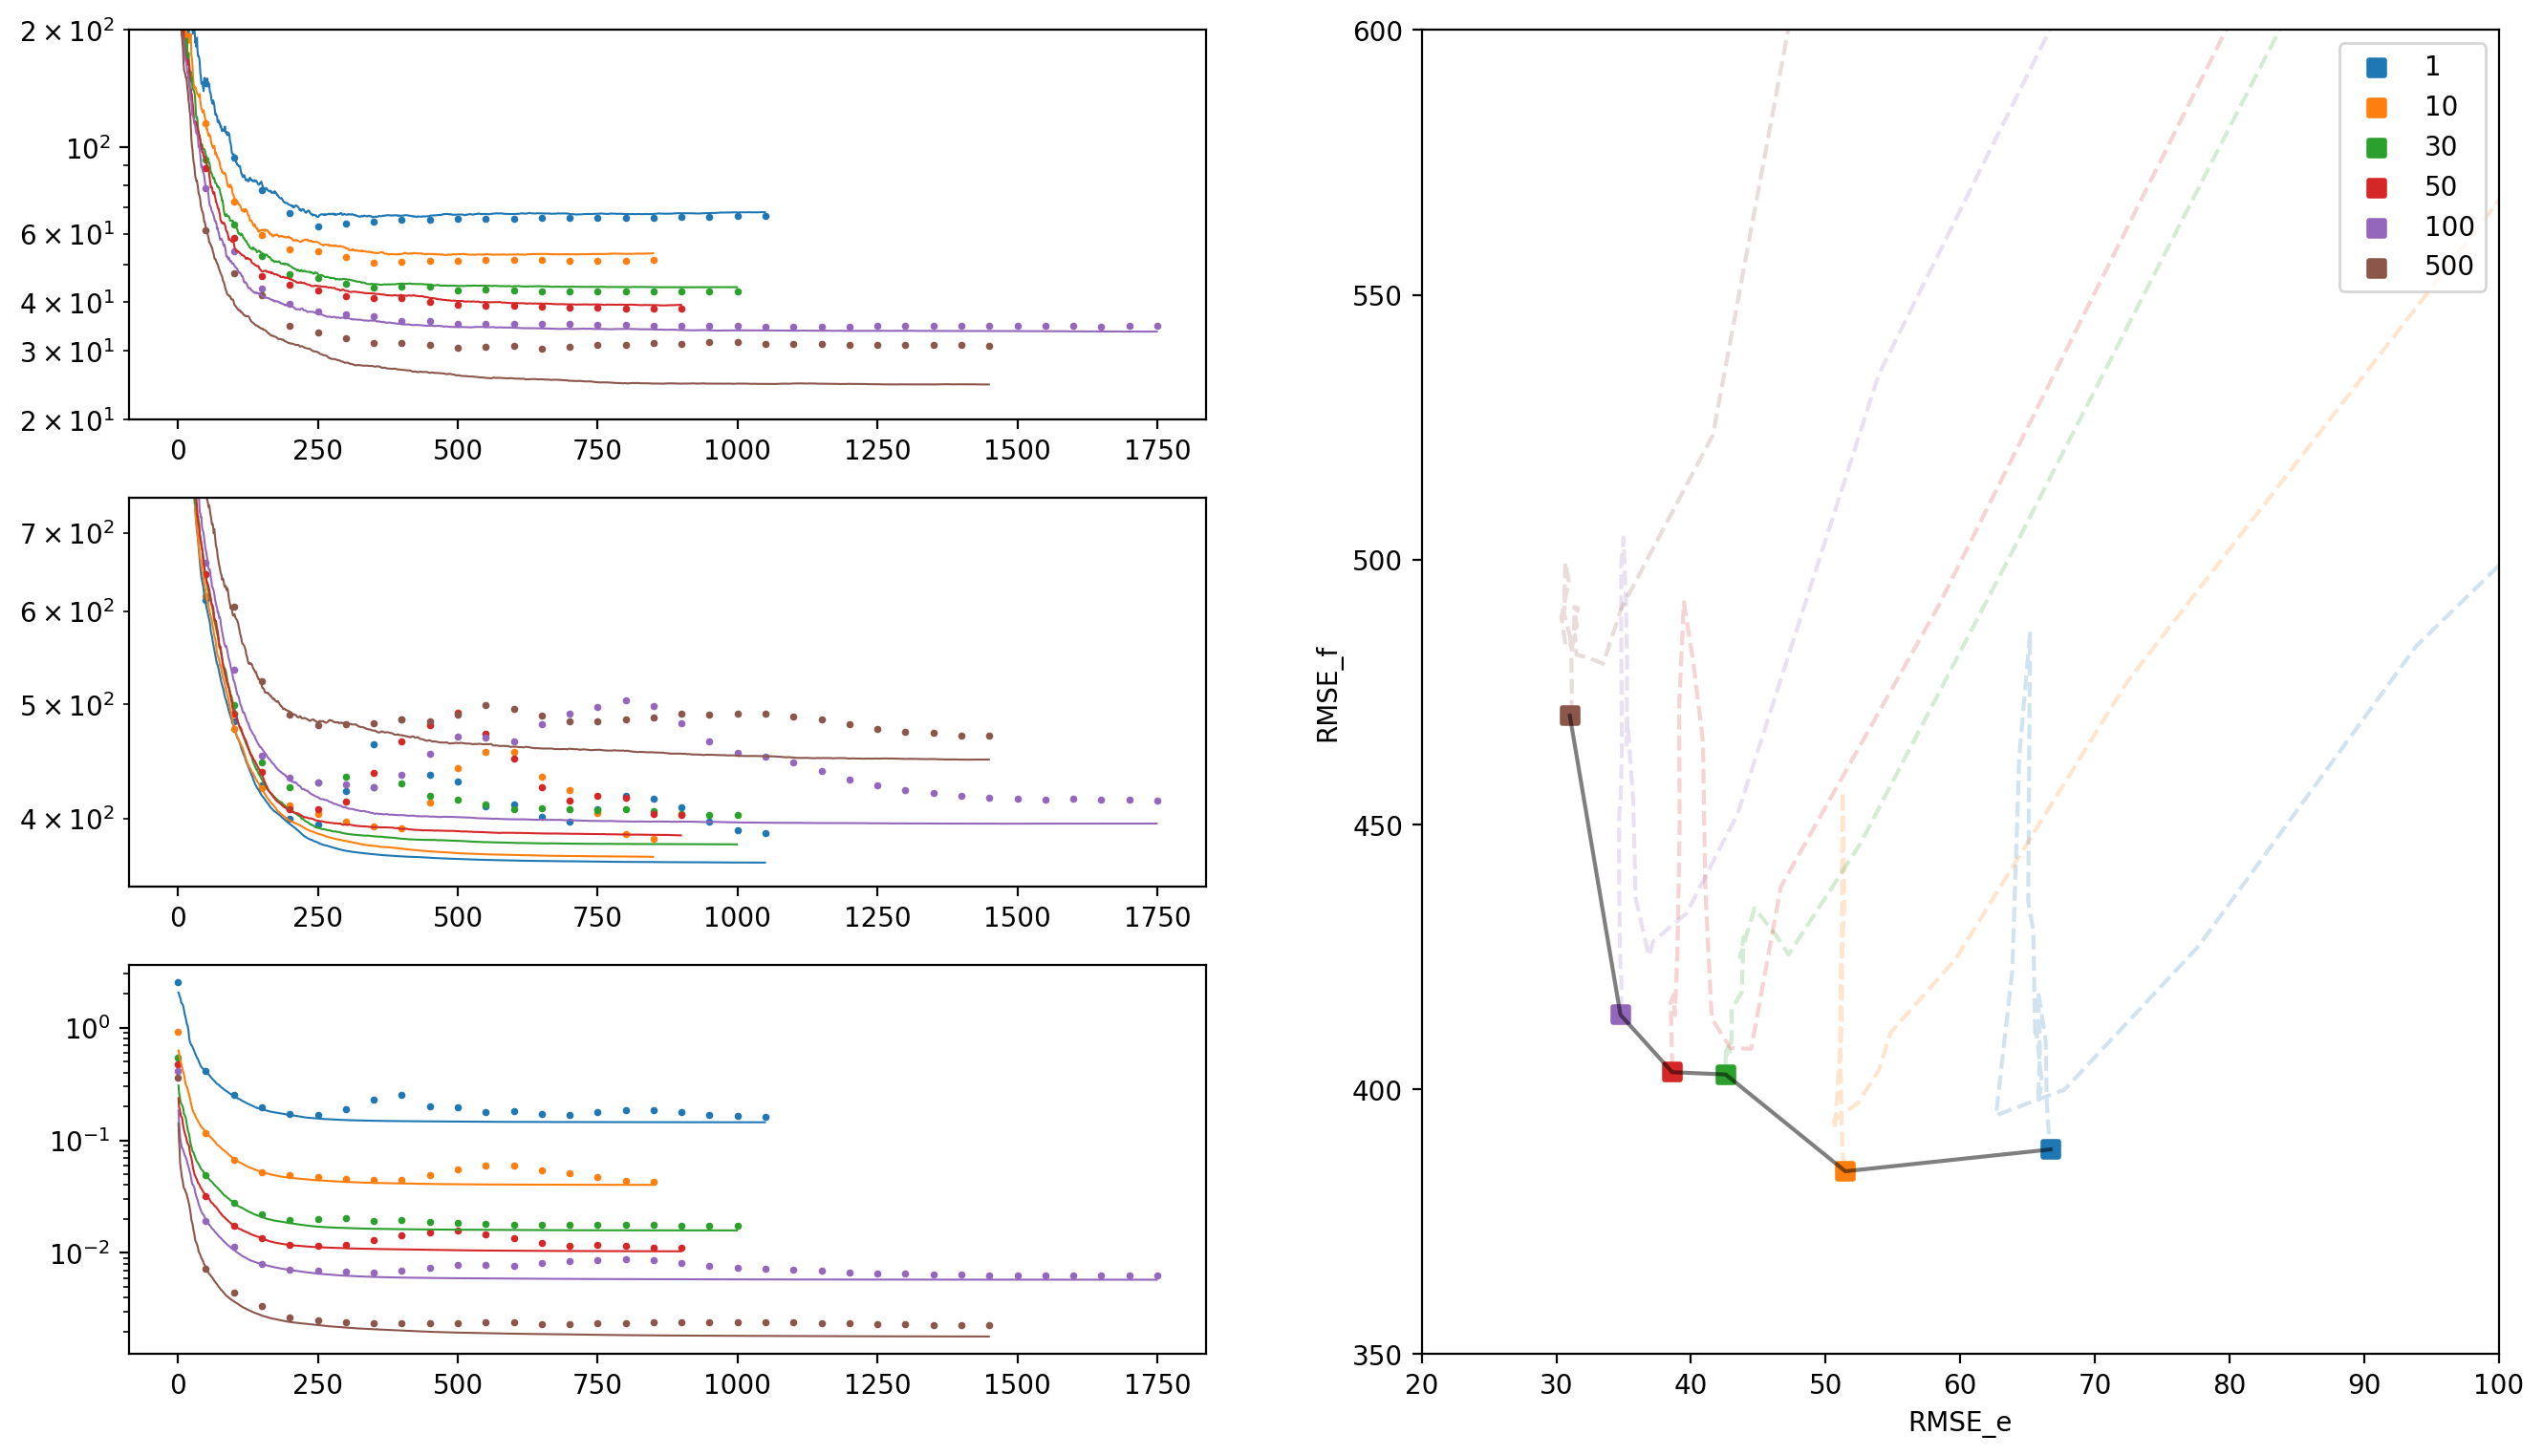

In [6]:
# Data loading
datadir = 'datafiles_response/Tr1k_n/'
kappavals = [1, 10, 30, 50, 100, 500]
trainloss = [np.loadtxt(datadir+'kappa'+str(kappa)+'/trainloss.dat').T for kappa in kappavals] # original is (entry, (iter,loss,rmse_e,rmse_f),iter)
valloss = [np.loadtxt(datadir+'kappa'+str(kappa)+'/valloss.dat').T for kappa in kappavals] # (entry,iter,loss,rmse_e,rmse_f)

# Plotting
f = plt.figure(figsize=(16,9),dpi=200)
axle = f.add_subplot(321); axlf = f.add_subplot(323); axl = f.add_subplot(325)
lax = [axl,axle,axlf]
axlelf = f.add_subplot(122)
for i,ax in enumerate(lax):
    for j,loss in enumerate(trainloss):
        ax.plot(loss[0],loss[i+1],lw=0.75)
        ax.scatter(valloss[j][0],valloss[j][i+1],s=3)
    ax.set_yscale('log')

axlelf_connectors = []
for k,errs in enumerate(valloss):
    axlelf.scatter(*errs[-2:][:,-1],label=kappavals[k],color='C'+str(k),marker='s',linewidth=2)
    axlelf_connectors.append([errs[-2:][:,-1][0], errs[-2:][:,-1][1]])
    axlelf.plot(*errs[-2:],color='C'+str(k),linestyle='--',alpha=0.2)

axlelf.plot(*np.array(axlelf_connectors).T,'k-',alpha=0.5)

axle.set_ylim(20,200)
axlf.set_ylim(350,750)
axlelf.set_ylim(350,600)
axlelf.set_xlim(20,100)
axlelf.set_ylabel('RMSE_f')
axlelf.set_xlabel('RMSE_e')
axlelf.legend(loc='upper right')

### Old vs. new lelf trajectories 

In [113]:
# g,ax = plt.subplots(1, 1, figsize=(16, 9), dpi=300)

# for k,errs in enumerate(valloss):
#     ax.scatter(*errs[-2:],color='C'+str(k),alpha=0.8,s=10)
#     ax.plot(*iterval_ef[k],color='C'+str(k),alpha=0.5)
#     ax.scatter(*iterval_ef_of[k],color='C'+str(k),marker='s',s=100)
# ax.set_ylim(350,600)
# ax.set_xlim(20,100)

### Dimer curves

(-10.0, 8.0)

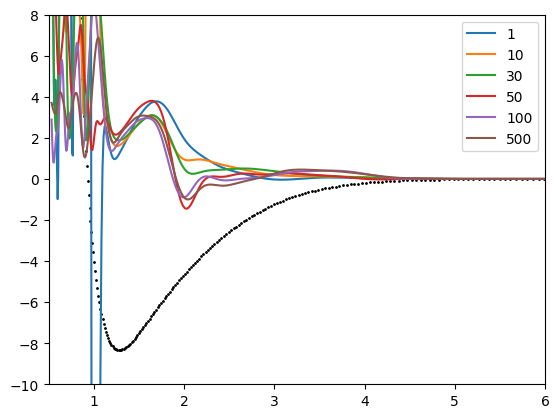

In [7]:
# Directories
datadir = 'datafiles_response/Tr1k_n/'
kappavals = [1, 10, 30, 50, 100, 500]
vals = ['kappa'+str(k) for k in kappavals]
potdirs = [datadir+v+'/' for v in vals]
potname = 'interim_potential_0.yaml'

# Data loading
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV
r = en_qe[0]

g,ax = plt.subplots(1,1)
ax.scatter(*en_qe,s=1,color='k')
for i, potdir in enumerate(potdirs):
    ax.plot(r, en_ase(r,potdir,potname),label=kappavals[i])
ax.legend(loc='upper right')
ax.set_xlim(0.5,6)
ax.set_ylim(-10,8)